In [1]:
from vyper.user import Model
import pandas as pd
from sklearn.utils import shuffle
from vyper.user.explorer import DataProfiler
from openpyxl import Workbook

import math
import numpy as np
from vyper.utils.tools import StatisticalTools as st
from sklearn.preprocessing import OrdinalEncoder
import scipy as stats
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from varclushi import VarClusHi
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
class Preprocessing:
    def __init__(self, data):  # to read the data
        self.df = pd.read_csv(data)

    def print(self):  # prints the data
        print(self.df)
        # return self.df

    def get_df(self):  # returns the data
        return self.df

    def print_shape(self):  # prints the shape of the data
        print(self.df.shape)
        return self.df.shape

    def df_list(self, list_of_columns):
        self.df = self.df[list_of_columns]
        return self.df

    def vyper(self, dv):  # model vyper
        m = Model(
            data=self.df,
            dependent_variable=dv,
            na_drop_threshold=0.5,  # set here when variables should be dropped 1 = none dropped
            training_percentage=0.7,  # set here % of dataset that should be training
            model_type="linear",
        )
        return m

    @staticmethod
    def show_variable_types(m):  # shows the variable types
        return m.variables.show_types()

    @staticmethod
    def quantile_function(a, bounds):
        lower_bound = np.quantile(a, q=(0.5 - bounds / 2), interpolation="nearest")
        upper_bound = np.quantile(a, q=(0.5 + bounds / 2), interpolation="nearest")
        final_bounds = [lower_bound, upper_bound]

        return final_bounds

    def recoding(self, bounds, min_bin_size, dv,
                 ordinal_variables=None):  # removed excluded_variables,numeric_variables,binary_variables,category_variables as parameters and introduced dependent variable as parameter

        if ordinal_variables is None:
            ordinal_variables = []
        m = self.vyper(dv)
        original_variables = m.data.columns.to_list()
        excluded_variables = m.variables.get_excluded_variables()
        category_variables = m.variables.get_categorical_variables()
        numeric_variables = m.variables.get_numeric_variables()
        binary_variables = m.variables.get_binary_variables()
        keep_variables = original_variables

        for var in excluded_variables:
            if var in self.df.columns:
                keep_variables.remove(var)
                self.df.drop(var, axis=1, inplace=True)

        for var in numeric_variables:
            if var in self.df.columns:
                Q3 = np.quantile(self.df[[var]], 0.75)
                Q1 = np.quantile(self.df[[var]], 0.25)
                IQR = Q3 - Q1

                if IQR == 0:
                    keep_variables.remove(var)
                    self.df.drop(var, axis=1, inplace=True)
                    print(
                        "The following variables is excluded due to inter quantile equal 0:"
                        + var
                    )

                else:
                    bnds = self.quantile_function(
                        [var for var in list(self.df[var]) if not math.isnan(var)],
                        bounds=bounds,
                    )
                    self.df[var + "_processed"] = pd.Series(
                        np.minimum(np.maximum(self.df[var], bnds[0]), bnds[1])
                    )
                    keep_variables.remove(var)
                    keep_variables.append(var + "_processed")
                    self.df = self.df[keep_variables]

        for var in ordinal_variables:
            if var in self.df.columns:
                training_data = self.df[[var]].drop_duplicates()
                training_data[var + "_processed"] = (
                        pd.factorize(training_data[var], sort=True)[0] + 1
                )
                self.df = self.df.merge(training_data, on=var)
                keep_variables.remove(var)
                keep_variables.append(var + "_processed")
                self.df = self.df[keep_variables]

        data_df_orig = self.df
        N = self.df.shape[0]

        for var in binary_variables:
            if var in self.df.columns:
                tab = self.df[var].value_counts(ascending=False)
                counter2 = 0
                counter1 = tab.iloc[1]
                counter2 = counter1 + counter2
                N_missing = sum(self.df[var].isna())

                if N_missing / N >= min_bin_size:
                    self.df[var + "_missing_ind"] = np.where(
                        self.df[var].isna() == 1, 1, 0
                    )
                    data_df_orig[var].fillna("TnImissing", inplace=True)

                else:
                    data_df_orig[var].fillna(tab.index[0], inplace=True)

                if counter2 / (N - N_missing) >= min_bin_size:
                    self.df[var + "_ind"] = np.where(self.df[var] == tab.index[1], 1, 0)
                self.df = self.df.drop([var], axis=1)

        self.df = pd.get_dummies(
            self.df, prefix=category_variables, columns=category_variables
        )

        for var in category_variables:
            if var in self.df.columns:  # changed from data_df_orig.columns to self.df.columns
                N_missing = sum(data_df_orig[var].isna())
                tab = data_df_orig[var].value_counts(ascending=False)

                if N_missing / N >= min_bin_size:
                    self.df[var + "_missing_ind"] = self.df[var].isna().astype(int)
                    data_df_orig[var].fillna("TnImissing", inplace=True)
                else:
                    data_df_orig[var].fillna(tab.index[0], inplace=True)

                self.df = self.df.drop([var + "_" + tab.index[0]], axis=1)
                counter2 = 0

                for ii in range(1, (len(tab) - 1)):
                    counter1 = tab.iloc[ii]
                    counter2 = counter1 + counter2
                    if counter2 / (N - N_missing) < min_bin_size:
                        self.df = self.df.drop([var + "_" + tab.index[ii]], axis=1)
                        data_df_orig[var] = np.where(
                            data_df_orig[var] == tab.index[ii],
                            tab.index[0],
                            data_df_orig[var],
                        )
                        counter2 = 0

        return self.df, data_df_orig, numeric_variables, binary_variables  # added numeric_variables, binary_variables as return values

    def missing_zero_values_table(self):

        zero_val = (self.df == 0.00).astype(int).sum(axis=0)
        mis_val = self.df.isnull().sum()
        mis_val_percent = (self.df.isnull().sum() / len(self.df)) * 100
        missing_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        missing_table = missing_table.rename(
            columns={0: "Zero Values", 1: "Missing Values", 2: "% of Total Values"}
        )
        missing_table["Total Zero + Missing Values"] = (
                missing_table["Zero Values"] + missing_table["Missing Values"]
        )
        missing_table["% Total Zero + Missing Values"] = (missing_table["Total Zero + Missing Values"] / len(
            self.df)) * 100
        missing_table["Data Type"] = self.df.dtypes
        missing_table = (
            missing_table[missing_table.iloc[:, 1] != 0]
            .sort_values("% of Total Values", ascending=False)
            .round(1)
        )

        return missing_table

    def drop_missing(self, thold):
        drop_list = []
        for cols in self.df.columns:
            if (self.df.loc[:, cols].isnull().sum() / len(self.df)) > int(thold):
                drop_list.append(cols)
        self.df.drop(drop_list, axis=1, inplace=True)

    def impute_na(self, cols, mth):  # mean, mode,  bfill, ffill
        if mth == "mean":
            for i in cols:
                if i in self.df.columns:
                    self.df[i].fillna(self.df[i].mean(), inplace=True)
        if mth == "mode":
            for i in cols:
                if i in self.df.columns:
                    self.df[i].fillna(self.df[i].mode()[0], inplace=True)
        if mth == "bfill":
            for i in cols:
                if i in self.df.columns:
                    self.df[i].fillna("bfill", inplace=True)
        if mth == "ffill":
            for i in cols:
                if i in self.df.columns:
                    self.df[i].fillna("ffill", inplace=True)

    def correlation(self, nv, threshold):  # nv = numeric variables which is returned from recoding function
        cols = self.df.columns
        newcol = []
        for col in nv:
            if col in cols:
                newcol.append(col)
        self.df = self.df[newcol]
        list1 = list()
        col_corr = set()  # Set of all the names of deleted columns
        corr_matrix = self.df.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if (corr_matrix.iloc[i, j] >= threshold) and (
                        corr_matrix.columns[j] not in col_corr
                ):
                    colname = corr_matrix.columns[i]  # getting the name of column
                    col_corr.add(colname)
                    if colname in self.df.columns:
                        list1.append(colname)
                        del self.df[colname]  # deleting the column from the self.df
        print("List of columns removed from the self.df : ", list1)
        return pd.DataFrame(self.df)

    def calculateMahalanobis(self, cov=None, alpha=0.01):

        y_mu = self.df - np.mean(self.df)
        if not cov:
            cov = np.cov(self.df.values.T)
        inv_covmat = np.linalg.inv(cov)
        left = np.dot(y_mu, inv_covmat)
        mahal = np.dot(left, y_mu.T)
        self.df['Mahalanobis'] = mahal.diagonal()
        # calculate p values Degrees of Freedom is number of columns
        self.df['p'] = 1 - chi2.cdf(self.df['Mahalanobis'], self.df.shape[1])
        # remove rows with p < alpha
        to_remove = len(self.df[self.df.p < alpha])
        print("Number of rows removed from dataset: ", to_remove)
        self.df = self.df[self.df.p > alpha]
        self.df.drop('Mahalanobis', axis=1, inplace=True)
        self.df.drop('p', axis=1, inplace=True)
        return self.df

    def outlier_capping(self, col, thold):

        mu = self.df[col].mean()
        sigma = self.df[col].std()
        scaled_data = (self.df[col] - mu) / sigma
        upper_limit = scaled_data.mean() + (thold * scaled_data.std())
        lower_limit = scaled_data.mean() - (thold * scaled_data.std())
        capped_data = np.where(scaled_data > upper_limit, upper_limit,
                               np.where(scaled_data < lower_limit, lower_limit, scaled_data))
        self.df[col] = capped_data * sigma + mu
        return self.df

    def oc(self, thold=3):
        for col in self.df.columns:
            self.outlier_capping(col, thold)
        return self.df

    def standardization(self):
        scaler = StandardScaler()
        scaled = scaler.fit_transform(self.df)
        self.df = pd.DataFrame(scaled, columns=self.df.columns)
        return self.df

    def var_clustering(self, maxeigval2=1, maxclus=None):
        var_clust_model = VarClusHi(self.df, maxeigval2=maxeigval2, maxclus=maxclus)
        var_clust_model.varclus()
        var_to_keep = list(
            var_clust_model.rsquare.sort_values(by=['Cluster', 'RS_Ratio']).groupby('Cluster').first().Variable)
        return var_clust_model.rsquare, var_to_keep
        # from here need to get the variable within a cluster with the lowest RS_Ratio and pick that one

    def len_var_clustering(self, maxeigval2=1, maxclus=None):
        var_clust_model = VarClusHi(self.df, maxeigval2=maxeigval2, maxclus=maxclus)
        var_clust_model.varclus()
        var_to_keep = list(
            var_clust_model.rsquare.sort_values(by=['Cluster', 'RS_Ratio']).groupby('Cluster').first().Variable)
        return len(var_to_keep)

    def tocsv(self,
              filename):
        # save the preprocessed data to csv file with the name of the original file excluding .csv  + _preprocessed
        return self.df.to_csv(filename + '_preprocessed.csv', index=False)

In [3]:
pps = Preprocessing('maurices.csv')

In [4]:
pps.get_df()

,indiv_id_mcvp,cc_flag,loyalty_flag,transactions,prod_clearanceflag_y,prod_clearanceflag_n,prod_markdown_ind_y,prod_markdown_ind_n,products_count,net_amt,cogs_amt,gross_amt,c3_denimcheck,c3_intimcheck,c3_girlcheck,c3_acccheck,c3_pluscheck,c3_core1check,c3_knit_graphicscheck,c3_online_onlycheck,c1_promo,c1_core,c1_girls,c1_accessories,c1_plus_apparel,c1_womens_apparel,c3_denimcheck_amt,c3_intimcheck_amt,c3_girlcheck_amt,c3_acccheck_amt,c3_pluscheck_amt,c3_online_onlycheck_amt,c3_knit_graphicscheck_amt,c3_core1check_amt,c1_promo_amt,c1_core_amt,c1_girls_amt,c1_accessories_amt,c1_plus_apparel_amt,c1_womens_apparel_amt,pos_locations_count,ecom_txn_count,pos_txn_count,ecom_txn_amt,pos_txn_amt,recency_days,fs_spring_txn_count,fs_fall_txn_count,s_holiday_txn_count,s_spring_txn_count,s_summer_txn_count,s_back_to_school_txn_count,cust_status,Unnamed: 53
0,1110000062532,(null),1,1,0,4,0,4,4,55.50,14.13,64.50,0,1,0,1,0,0,2,0,0,0,0,2,0,2,0.00,13.50,0.0,10.50,0.00,0.0,31.50,0.00,0.0,0.00,0.0,24.00,0.00,31.50,1,0,1,0.00,55.50,632,0,1,0,0,0,1,sleeping,0.0
1,1110000157475,(null),1,1,0,2,0,2,2,49.85,14.43,64.80,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0.00,0.00,0.0,0.00,0.00,0.0,26.85,23.00,0.0,0.00,0.0,0.00,26.85,23.00,1,0,1,0.00,49.85,351,1,0,0,0,1,0,reactivated,NaN
2,1110000182623,(null),1,19,0,57,24,33,57,798.25,347.68,1031.43,4,0,0,1,9,7,36,0,0,5,0,1,48,3,95.18,0.00,0.0,7.98,165.40,0.0,500.89,28.80,0.0,11.13,0.0,7.98,754.48,24.66,4,3,16,269.83,528.42,162,9,10,4,6,5,4,retained,NaN
3,1110000208094,(null),1,6,0,13,2,11,13,217.56,80.14,288.77,1,0,0,5,0,3,4,0,0,2,0,5,0,6,29.94,0.00,0.0,105.74,0.00,0.0,69.80,12.08,0.0,0.10,0.0,105.74,0.00,111.72,3,0,6,0.00,217.56,107,4,2,1,2,3,0,retained,NaN
4,1110000211279,(null),1,1,0,3,0,3,3,94.75,28.23,109.70,1,1,0,0,0,0,1,0,0,0,0,1,1,1,49.93,19.90,0.0,0.00,0.00,0.0,24.92,0.00,0.0,0.00,0.0,19.90,49.93,24.92,1,0,1,0.00,94.75,8,1,0,0,0,1,0,reactivated,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,1110094326747,(null),1,1,0,3,0,3,3,56.75,19.91,56.75,0,0,0,0,2,1,0,0,0,1,0,0,2,0,0.00,0.00,0.0,0.00,49.80,0.0,0.00,6.95,0.0,6.95,0.0,0.00,49.80,0.00,0,1,0,56.75,0.00,35,1,0,0,1,0,0,new,NaN
99938,1110094493474,(null),1,2,0,6,0,6,6,63.55,22.15,100.40,0,1,0,1,1,0,3,0,0,0,0,2,4,0,0.00,0.00,0.0,6.42,17.94,0.0,39.19,0.00,0.0,0.00,0.0,6.42,57.13,0.00,2,0,2,0.00,63.55,16,2,0,0,1,1,0,new,NaN
99939,1110094536950,1,1,1,0,8,2,6,8,35.67,19.66,61.36,0,6,0,0,0,0,2,0,0,0,0,6,2,0,0.00,18.70,0.0,0.00,0.00,0.0,16.97,0.00,0.0,0.00,0.0,18.70,16.97,0.00,1,0,1,0.00,35.67,10,1,0,0,0,1,0,new,NaN
99940,1110094542620,1,1,1,0,6,0,6,6,116.86,48.26,196.40,1,1,0,2,0,1,1,0,0,0,0,3,0,3,32.67,11.84,0.0,33.79,0.00,0.0,14.82,23.74,0.0,0.00,0.0,45.63,0.00,71.23,1,0,1,0.00,116.86,9,1,0,0,0,1,0,new,NaN


In [5]:
a, B, nv, bv = pps.recoding(0.98, 0.1, 'indiv_id_mcvp', )

The following variables is excluded due to inter quantile equal 0:pos_locations_count
The following variables is excluded due to inter quantile equal 0:c3_intimcheck_amt
The following variables is excluded due to inter quantile equal 0:c3_pluscheck
The following variables is excluded due to inter quantile equal 0:c3_pluscheck_amt
The following variables is excluded due to inter quantile equal 0:c3_intimcheck
The following variables is excluded due to inter quantile equal 0:c1_core_amt


In [6]:
pps.get_df()

,c1_plus_apparel_processed,c3_acccheck_processed,pos_txn_count_processed,c1_core_processed,c3_knit_graphicscheck_processed,c3_denimcheck_amt_processed,c1_plus_apparel_amt_processed,net_amt_processed,c3_acccheck_amt_processed,ecom_txn_count_processed,products_count_processed,prod_markdown_ind_n_processed,s_spring_txn_count_processed,s_back_to_school_txn_count_processed,cogs_amt_processed,pos_txn_amt_processed,prod_markdown_ind_y_processed,s_summer_txn_count_processed,c3_knit_graphicscheck_amt_processed,c1_womens_apparel_amt_processed,c1_womens_apparel_processed,c1_accessories_amt_processed,c3_core1check_amt_processed,c1_accessories_processed,c3_core1check_processed,recency_days_processed,fs_spring_txn_count_processed,prod_clearanceflag_n_processed,s_holiday_txn_count_processed,ecom_txn_amt_processed,fs_fall_txn_count_processed,transactions_processed,gross_amt_processed,c3_denimcheck_processed,cc_flag_ind,loyalty_flag_ind,cust_status_new,cust_status_reactivated,cust_status_retained,cust_status_sleeping
0,0,1,1,0,2,0.00,0.00,55.50,10.50,0,4,4,0,1,14.13,55.50,0,0,31.50,31.50,2,24.00,0.00,2,0,632,0,4,0,0.00,1,1,64.50,0,0,0,0,0,0,1
1,1,0,1,0,1,0.00,26.85,49.85,0.00,0,2,2,0,0,14.43,49.85,0,1,26.85,23.00,1,0.00,23.00,0,1,351,1,2,0,0.00,0,1,64.80,0,0,0,0,1,0,0
2,41,1,16,5,36,95.18,754.48,798.25,7.98,3,57,33,6,4,347.68,528.42,24,5,500.89,24.66,3,7.98,28.80,1,7,162,9,57,4,269.83,10,19,1031.43,4,0,0,0,0,1,0
3,0,5,6,2,4,29.94,0.00,217.56,105.74,0,13,11,2,0,80.14,217.56,2,3,69.80,111.72,6,105.74,12.08,5,3,107,4,13,1,0.00,2,6,288.77,1,0,0,0,0,1,0
4,1,0,1,0,1,49.93,49.93,94.75,0.00,0,3,3,0,0,28.23,94.75,0,1,24.92,24.92,1,19.90,0.00,1,0,8,1,3,0,0.00,0,1,109.70,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,2,0,0,1,0,0.00,49.80,56.75,0.00,1,3,3,1,0,19.91,0.00,0,0,0.00,0.00,0,0.00,6.95,0,1,35,1,3,0,56.75,0,1,56.75,0,0,0,1,0,0,0
99938,4,1,2,0,3,0.00,57.13,63.55,6.42,0,6,6,1,0,22.15,63.55,0,1,39.19,0.00,0,6.42,0.00,2,0,16,2,6,0,0.00,0,2,100.40,0,0,0,1,0,0,0
99939,2,0,1,0,2,0.00,16.97,35.67,0.00,0,8,6,0,0,19.66,35.67,2,1,16.97,0.00,0,18.70,0.00,6,0,10,1,8,0,0.00,0,1,61.36,0,1,0,1,0,0,0
99940,0,2,1,0,1,32.67,0.00,116.86,33.79,0,6,6,0,0,48.26,116.86,0,1,14.82,71.23,3,45.63,23.74,3,1,9,1,6,0,0.00,0,1,196.40,1,1,0,1,0,0,0


In [7]:
pps.missing_zero_values_table()

,Zero Values,Missing Values,% of Total Values,Total Zero + Missing Values,% Total Zero + Missing Values,Data Type


In [8]:
num_vars = [s + '_processed' for s in nv]
bin_vars = [s + '_ind' for s in bv]

In [9]:
# pps.impute_na(num_vars, 'mean')
# pps.impute_na(bin_vars, 'mode')

In [10]:
pps.correlation(num_vars, 0.8)

List of columns removed from the self.df :  ['c1_plus_apparel_amt_processed', 'net_amt_processed', 'c3_acccheck_amt_processed', 'ecom_txn_count_processed', 'products_count_processed', 'prod_markdown_ind_n_processed', 'cogs_amt_processed', 'pos_txn_amt_processed', 'c3_knit_graphicscheck_amt_processed', 'c1_womens_apparel_processed', 'c1_accessories_amt_processed', 'c3_core1check_amt_processed', 'c1_accessories_processed', 'c3_core1check_processed', 'fs_spring_txn_count_processed', 'prod_clearanceflag_n_processed', 'ecom_txn_amt_processed', 'fs_fall_txn_count_processed', 'transactions_processed', 'gross_amt_processed', 'c3_denimcheck_processed']


,c1_plus_apparel_processed,c3_acccheck_processed,pos_txn_count_processed,c1_core_processed,c3_knit_graphicscheck_processed,c3_denimcheck_amt_processed,s_spring_txn_count_processed,s_back_to_school_txn_count_processed,prod_markdown_ind_y_processed,s_summer_txn_count_processed,c1_womens_apparel_amt_processed,recency_days_processed,s_holiday_txn_count_processed
0,0,1,1,0,2,0.00,0,1,0,0,31.50,632,0
1,1,0,1,0,1,0.00,0,0,0,1,23.00,351,0
2,41,1,16,5,36,95.18,6,4,24,5,24.66,162,4
3,0,5,6,2,4,29.94,2,0,2,3,111.72,107,1
4,1,0,1,0,1,49.93,0,0,0,1,24.92,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,2,0,0,1,0,0.00,1,0,0,0,0.00,35,0
99938,4,1,2,0,3,0.00,1,0,0,1,0.00,16,0
99939,2,0,1,0,2,0.00,0,0,2,1,0.00,10,0
99940,0,2,1,0,1,32.67,0,0,0,1,71.23,9,0


In [11]:
pps.oc(6)

,c1_plus_apparel_processed,c3_acccheck_processed,pos_txn_count_processed,c1_core_processed,c3_knit_graphicscheck_processed,c3_denimcheck_amt_processed,s_spring_txn_count_processed,s_back_to_school_txn_count_processed,prod_markdown_ind_y_processed,s_summer_txn_count_processed,c1_womens_apparel_amt_processed,recency_days_processed,s_holiday_txn_count_processed
0,0.000000,1.0,1.0,0.0,2.0,0.00,0.0,1.0,0.0,0.0,31.50,632.0,0.0
1,1.000000,0.0,1.0,0.0,1.0,0.00,0.0,0.0,0.0,1.0,23.00,351.0,0.0
2,40.635294,1.0,16.0,5.0,36.0,95.18,6.0,4.0,24.0,5.0,24.66,162.0,4.0
3,0.000000,5.0,6.0,2.0,4.0,29.94,2.0,0.0,2.0,3.0,111.72,107.0,1.0
4,1.000000,0.0,1.0,0.0,1.0,49.93,0.0,0.0,0.0,1.0,24.92,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,2.000000,0.0,0.0,1.0,0.0,0.00,1.0,0.0,0.0,0.0,0.00,35.0,0.0
99938,4.000000,1.0,2.0,0.0,3.0,0.00,1.0,0.0,0.0,1.0,0.00,16.0,0.0
99939,2.000000,0.0,1.0,0.0,2.0,0.00,0.0,0.0,2.0,1.0,0.00,10.0,0.0
99940,0.000000,2.0,1.0,0.0,1.0,32.67,0.0,0.0,0.0,1.0,71.23,9.0,0.0


In [12]:
pps.standardization()

,c1_plus_apparel_processed,c3_acccheck_processed,pos_txn_count_processed,c1_core_processed,c3_knit_graphicscheck_processed,c3_denimcheck_amt_processed,s_spring_txn_count_processed,s_back_to_school_txn_count_processed,prod_markdown_ind_y_processed,s_summer_txn_count_processed,c1_womens_apparel_amt_processed,recency_days_processed,s_holiday_txn_count_processed
0,-0.387664,-0.224030,-0.484690,-0.450471,-0.373486,-0.572478,-0.569299,0.008633,-0.517473,-0.591079,-0.496073,1.922005,-0.614303
1,-0.229936,-0.515294,-0.484690,-0.450471,-0.485201,-0.572478,-0.569299,-0.600672,-0.517473,0.026394,-0.524870,0.521830,-0.614303
2,6.021634,-0.224030,3.233065,1.590001,3.424822,0.268529,3.223070,1.836549,4.412990,2.496285,-0.519246,-0.419925,1.281749
3,-0.387664,0.941024,0.754562,0.365718,-0.150057,-0.307929,0.694824,-0.600672,-0.106601,1.261339,-0.224299,-0.693981,-0.140290
4,-0.229936,-0.515294,-0.484690,-0.450471,-0.485201,-0.131299,-0.569299,-0.600672,-0.517473,0.026394,-0.518365,-1.187281,-0.614303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,-0.072209,-0.515294,-0.732540,-0.042377,-0.596916,-0.572478,0.062762,-0.600672,-0.517473,-0.591079,-0.602790,-1.052744,-0.614303
99938,0.243246,-0.224030,-0.236839,-0.450471,-0.261771,-0.572478,0.062762,-0.600672,-0.517473,0.026394,-0.602790,-1.147418,-0.614303
99939,-0.072209,-0.515294,-0.484690,-0.450471,-0.373486,-0.572478,-0.569299,-0.600672,-0.106601,0.026394,-0.602790,-1.177315,-0.614303
99940,-0.387664,0.067233,-0.484690,-0.450471,-0.485201,-0.283807,-0.569299,-0.600672,-0.517473,0.026394,-0.361473,-1.182298,-0.614303


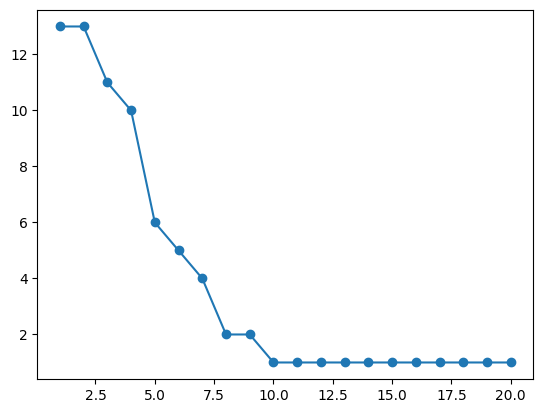

In [13]:
import matplotlib.pyplot as plt

x, y = [], []
for i in range(1, 21):
    x.append(i)
    y.append(pps.len_var_clustering(maxeigval2=i / 10))
plt.plot(x, y, '-o')
plt.show()

In [14]:
a,b=pps.var_clustering(0.25)

In [15]:
pps.get_df()

,c1_plus_apparel_processed,c3_acccheck_processed,pos_txn_count_processed,c1_core_processed,c3_knit_graphicscheck_processed,c3_denimcheck_amt_processed,s_spring_txn_count_processed,s_back_to_school_txn_count_processed,prod_markdown_ind_y_processed,s_summer_txn_count_processed,c1_womens_apparel_amt_processed,recency_days_processed,s_holiday_txn_count_processed
0,-0.387664,-0.224030,-0.484690,-0.450471,-0.373486,-0.572478,-0.569299,0.008633,-0.517473,-0.591079,-0.496073,1.922005,-0.614303
1,-0.229936,-0.515294,-0.484690,-0.450471,-0.485201,-0.572478,-0.569299,-0.600672,-0.517473,0.026394,-0.524870,0.521830,-0.614303
2,6.021634,-0.224030,3.233065,1.590001,3.424822,0.268529,3.223070,1.836549,4.412990,2.496285,-0.519246,-0.419925,1.281749
3,-0.387664,0.941024,0.754562,0.365718,-0.150057,-0.307929,0.694824,-0.600672,-0.106601,1.261339,-0.224299,-0.693981,-0.140290
4,-0.229936,-0.515294,-0.484690,-0.450471,-0.485201,-0.131299,-0.569299,-0.600672,-0.517473,0.026394,-0.518365,-1.187281,-0.614303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,-0.072209,-0.515294,-0.732540,-0.042377,-0.596916,-0.572478,0.062762,-0.600672,-0.517473,-0.591079,-0.602790,-1.052744,-0.614303
99938,0.243246,-0.224030,-0.236839,-0.450471,-0.261771,-0.572478,0.062762,-0.600672,-0.517473,0.026394,-0.602790,-1.147418,-0.614303
99939,-0.072209,-0.515294,-0.484690,-0.450471,-0.373486,-0.572478,-0.569299,-0.600672,-0.106601,0.026394,-0.602790,-1.177315,-0.614303
99940,-0.387664,0.067233,-0.484690,-0.450471,-0.485201,-0.283807,-0.569299,-0.600672,-0.517473,0.026394,-0.361473,-1.182298,-0.614303


In [16]:
pps.df_list(b)

,s_holiday_txn_count_processed,recency_days_processed,c1_plus_apparel_processed,c1_core_processed,c1_womens_apparel_amt_processed,s_spring_txn_count_processed,c3_acccheck_processed,s_summer_txn_count_processed,s_back_to_school_txn_count_processed,prod_markdown_ind_y_processed,c3_denimcheck_amt_processed,c3_knit_graphicscheck_processed,pos_txn_count_processed
0,-0.614303,1.922005,-0.387664,-0.450471,-0.496073,-0.569299,-0.224030,-0.591079,0.008633,-0.517473,-0.572478,-0.373486,-0.484690
1,-0.614303,0.521830,-0.229936,-0.450471,-0.524870,-0.569299,-0.515294,0.026394,-0.600672,-0.517473,-0.572478,-0.485201,-0.484690
2,1.281749,-0.419925,6.021634,1.590001,-0.519246,3.223070,-0.224030,2.496285,1.836549,4.412990,0.268529,3.424822,3.233065
3,-0.140290,-0.693981,-0.387664,0.365718,-0.224299,0.694824,0.941024,1.261339,-0.600672,-0.106601,-0.307929,-0.150057,0.754562
4,-0.614303,-1.187281,-0.229936,-0.450471,-0.518365,-0.569299,-0.515294,0.026394,-0.600672,-0.517473,-0.131299,-0.485201,-0.484690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,-0.614303,-1.052744,-0.072209,-0.042377,-0.602790,0.062762,-0.515294,-0.591079,-0.600672,-0.517473,-0.572478,-0.596916,-0.732540
99938,-0.614303,-1.147418,0.243246,-0.450471,-0.602790,0.062762,-0.224030,0.026394,-0.600672,-0.517473,-0.572478,-0.261771,-0.236839
99939,-0.614303,-1.177315,-0.072209,-0.450471,-0.602790,-0.569299,-0.515294,0.026394,-0.600672,-0.106601,-0.572478,-0.373486,-0.484690
99940,-0.614303,-1.182298,-0.387664,-0.450471,-0.361473,-0.569299,0.067233,0.026394,-0.600672,-0.517473,-0.283807,-0.485201,-0.484690


In [17]:
pps.get_df()

,s_holiday_txn_count_processed,recency_days_processed,c1_plus_apparel_processed,c1_core_processed,c1_womens_apparel_amt_processed,s_spring_txn_count_processed,c3_acccheck_processed,s_summer_txn_count_processed,s_back_to_school_txn_count_processed,prod_markdown_ind_y_processed,c3_denimcheck_amt_processed,c3_knit_graphicscheck_processed,pos_txn_count_processed
0,-0.614303,1.922005,-0.387664,-0.450471,-0.496073,-0.569299,-0.224030,-0.591079,0.008633,-0.517473,-0.572478,-0.373486,-0.484690
1,-0.614303,0.521830,-0.229936,-0.450471,-0.524870,-0.569299,-0.515294,0.026394,-0.600672,-0.517473,-0.572478,-0.485201,-0.484690
2,1.281749,-0.419925,6.021634,1.590001,-0.519246,3.223070,-0.224030,2.496285,1.836549,4.412990,0.268529,3.424822,3.233065
3,-0.140290,-0.693981,-0.387664,0.365718,-0.224299,0.694824,0.941024,1.261339,-0.600672,-0.106601,-0.307929,-0.150057,0.754562
4,-0.614303,-1.187281,-0.229936,-0.450471,-0.518365,-0.569299,-0.515294,0.026394,-0.600672,-0.517473,-0.131299,-0.485201,-0.484690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99937,-0.614303,-1.052744,-0.072209,-0.042377,-0.602790,0.062762,-0.515294,-0.591079,-0.600672,-0.517473,-0.572478,-0.596916,-0.732540
99938,-0.614303,-1.147418,0.243246,-0.450471,-0.602790,0.062762,-0.224030,0.026394,-0.600672,-0.517473,-0.572478,-0.261771,-0.236839
99939,-0.614303,-1.177315,-0.072209,-0.450471,-0.602790,-0.569299,-0.515294,0.026394,-0.600672,-0.106601,-0.572478,-0.373486,-0.484690
99940,-0.614303,-1.182298,-0.387664,-0.450471,-0.361473,-0.569299,0.067233,0.026394,-0.600672,-0.517473,-0.283807,-0.485201,-0.484690


In [18]:
# pps.tocsv('maurices_oc')

In [19]:
from my_library.algorithms.k_means import k_means as km

In [20]:
kms = km.Kmeans('maurices_oc_preprocessed.csv')

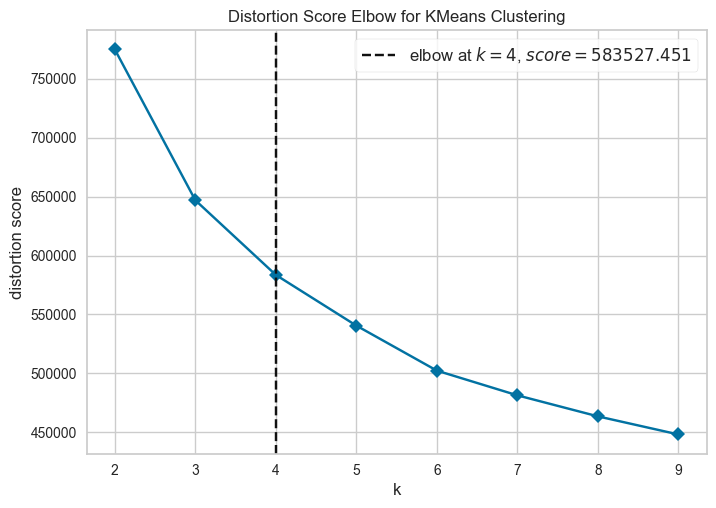

In [21]:
k_n=kms.elbow(2, 10)

In [22]:
# kms.kmeans_minClusterSize(k_n, 10000)
# kms.kmeans_maxClusterSize(k_n, 10000)

In [23]:
clus = kms.kmeans(k_n, 5000, 30000)

In [24]:
pca = kms.pca(clus)

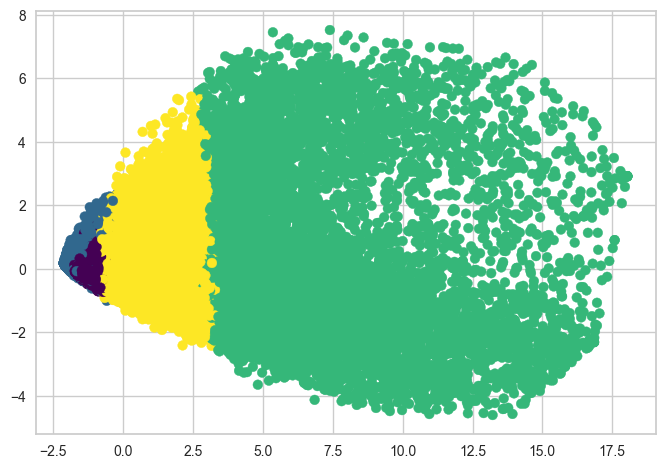

In [25]:
kms.scatter_plot(pca)